# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [4]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [5]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, який складається з 128 нейронів
        self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
        # Другий шар, який складається з 256 нейронів
        self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
        # Вихідний шар
        self.out_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes) 


    def __call__(self, x):
        # Передача даних через перші два шари та вихідний шар з функцією активації softmax
        x1 = self.layer_1(x, activation=0)
        x2 = self.layer_2(x1, activation=0)
        x3 = self.out_layer(x2, activation=1)

        return x3

In [6]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

    
# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    y_pred_argmax = tf.argmax(y_pred, axis=1)
    y_true_cast = tf.cast(y_true, tf.int64)

    # compare y_pred with y_true
    correct_predictions = tf.equal(y_pred_argmax, y_true_cast)

    # find middle accuracy 
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

    return accuracy

In [7]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  #optimizer = tf.optimizers.SGD(learning_rate)
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate)
  # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

        # Отримаємо список оптимізованих параметрів
        trainable_variables = neural_net.trainable_variables
        # Обчислимо за ними значення градієнта
        gradients = g.gradient(loss, trainable_variables)

        # Модифікуємо параметри
        optimizer.apply_gradients(zip(gradients, trainable_variables))

In [8]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        loss_history.append(loss)
        
        acc = accuracy(pred, batch_y)
        accuracy_history.append(acc)
        print(f"Step: {step}, loss: {loss:.4f}, accuracy: {acc:.4f}")

2024-04-28 10:36:08.963005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [60000]
	 [[{{node Placeholder/_1}}]]
2024-04-28 10:36:08.963266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [60000]
	 [[{{node Placeholder/_1}}]]


Step: 100, loss: 308.9658, accuracy: 0.7031
Step: 200, loss: 216.1387, accuracy: 0.7891
Step: 300, loss: 209.2078, accuracy: 0.7891
Step: 400, loss: 193.9239, accuracy: 0.7734
Step: 500, loss: 179.3687, accuracy: 0.8320
Step: 600, loss: 146.9989, accuracy: 0.8398
Step: 700, loss: 97.3626, accuracy: 0.8984
Step: 800, loss: 84.4100, accuracy: 0.8906
Step: 900, loss: 121.3421, accuracy: 0.8594
Step: 1000, loss: 75.0279, accuracy: 0.9062
Step: 1100, loss: 110.2013, accuracy: 0.8906
Step: 1200, loss: 69.0198, accuracy: 0.9258
Step: 1300, loss: 96.3452, accuracy: 0.8867
Step: 1400, loss: 98.7159, accuracy: 0.8984
Step: 1500, loss: 89.8648, accuracy: 0.8945
Step: 1600, loss: 56.2500, accuracy: 0.9297
Step: 1700, loss: 97.1859, accuracy: 0.9023
Step: 1800, loss: 67.3543, accuracy: 0.9219
Step: 1900, loss: 84.9692, accuracy: 0.8984
Step: 2000, loss: 55.4415, accuracy: 0.9219
Step: 2100, loss: 73.1786, accuracy: 0.9258
Step: 2200, loss: 101.3548, accuracy: 0.9102
Step: 2300, loss: 74.9100, accur

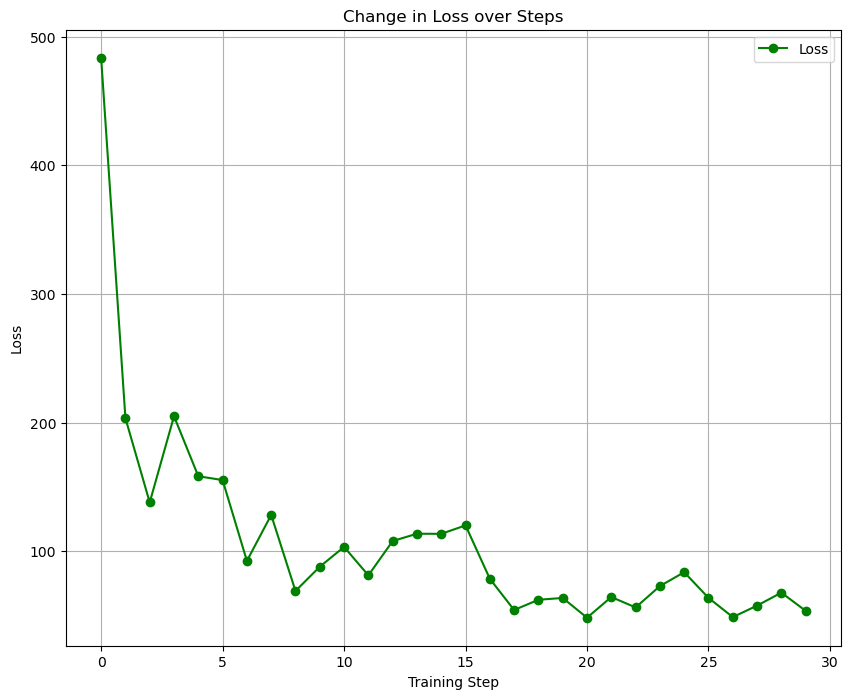

In [16]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(10, 8))
plt.plot(loss_history, label='Loss', marker='o', color="green")
plt.title('Change in Loss over Steps')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

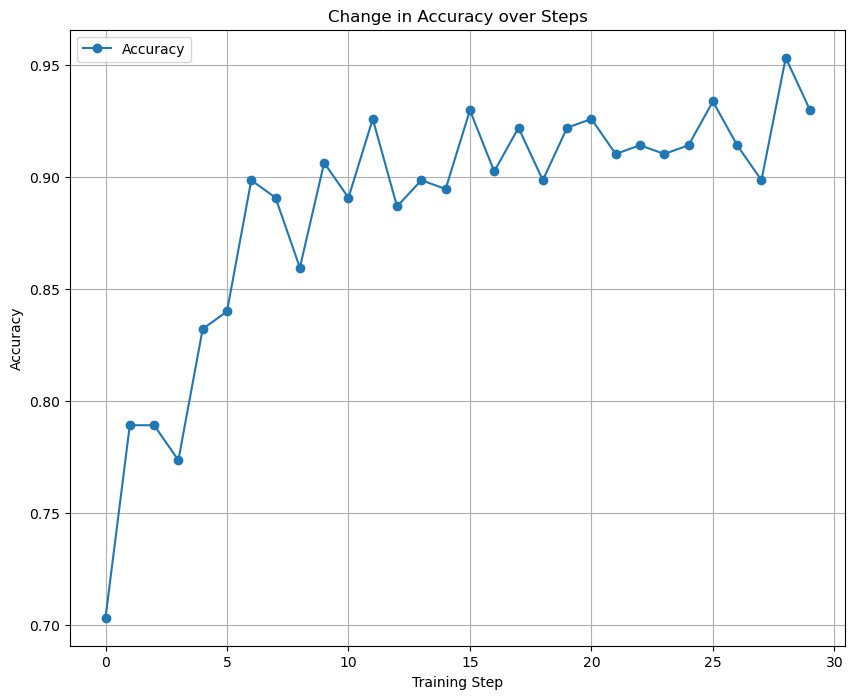

In [9]:
# Виведіть графік точності
# Місце для вашого коду
plt.figure(figsize=(10, 8))

plt.plot(accuracy_history, label='Accuracy', marker='o')
plt.title('Change in Accuracy over Steps')
plt.xlabel('Training Step')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

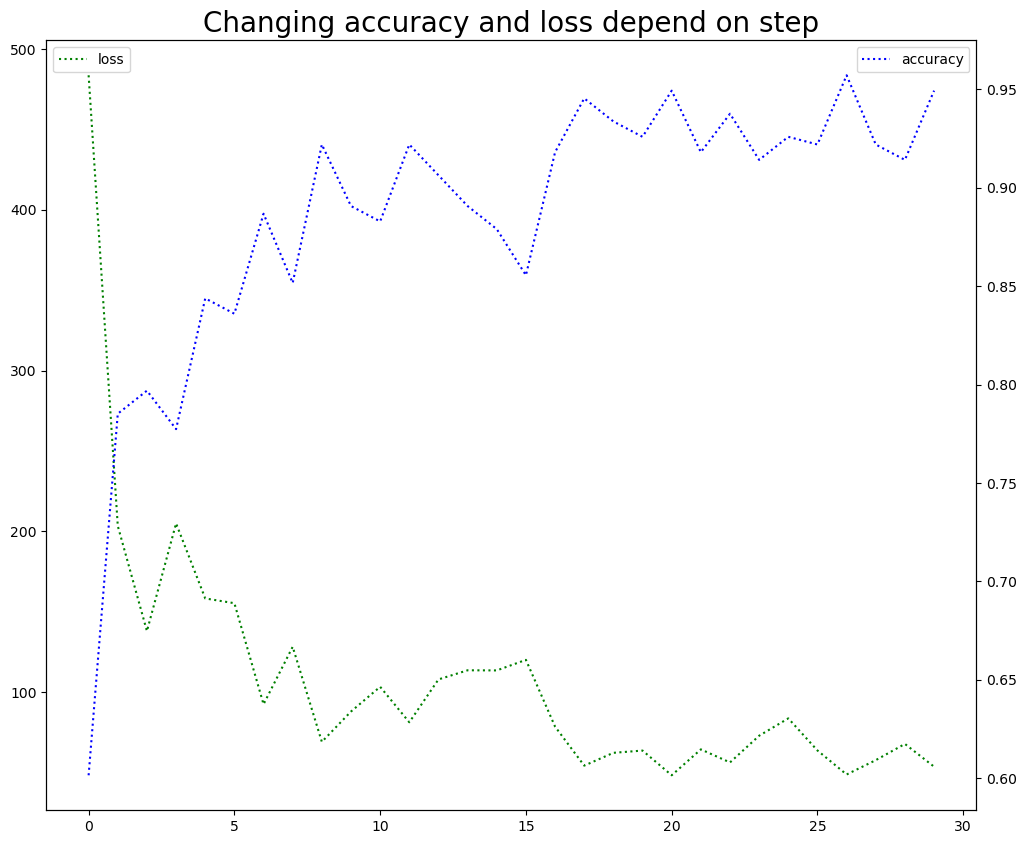

In [22]:
fig, axs = plt.subplots(figsize=(12, 10))
axs.plot(loss_history, 'green', label='loss', linestyle=":")

axs2=axs.twinx()
axs2.plot(accuracy_history, 'blue', label='accuracy', linestyle=":")
# Set legends
axs.legend(loc='upper left')
axs2.legend(loc='upper right')

plt.title('Changing accuracy and loss depend on step', fontsize=20)
plt.show()

In [23]:
# Обчисліть точність навченої нейромережі
# Тестування моделі на тестових даних
pred_train = neural_net(x_train)
acc_train = accuracy(pred_train, y_train)
print(f"Final Accuracy on Training data: {acc_train}")

test_pred = neural_net(x_test)
test_acc = accuracy(test_pred, y_test)
print(f"Accuracy on Test data: {test_acc}")

Final Accuracy on Training data: 0.9220166802406311
Accuracy on Test data: 0.9050999879837036


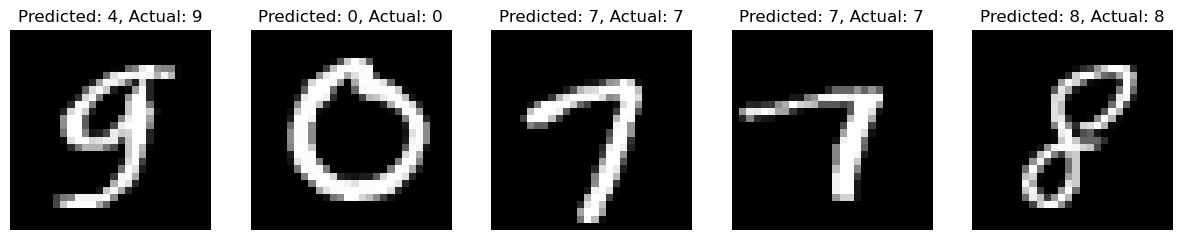

In [26]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
random_indices = np.random.choice(len(x_test), 5)
images_to_test = x_test[random_indices]
labels_to_test = y_test[random_indices]

# випадкових зображень і передайте їх у нейронну мережу.
pred = neural_net(images_to_test)

# Виведіть зображення та випишіть  поруч відповідь нейромережі.
plt.figure(figsize=(15, 5))
for el in range(5):
    plt.subplot(1, 5, el+1)
    plt.imshow(images_to_test[el].reshape((28, 28)), cmap='gray')
    plt.title(f"Predicted: {tf.argmax(pred[el], axis=0).numpy()}, Actual: {labels_to_test[el]}")
    plt.axis('off')
plt.show()
    
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

### Result:
> The neural network trained on the MNIST dataset has achieved an impressive accuracy of approximately 90,5%. This indicates that the model is performing well in classifying handwritten digits. Achieving such a high accuracy rate demonstrates the effectiveness of the model architecture, training process, and optimization techniques employed.
While a 90,5% accuracy rate is commendable, it's essential to consider potential areas for further improvement.